In [ ]:
pip install scikit-learn==0.22.2.post1
pip install --upgrade scikit-learn
pip install opencv-python
pip install keras

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow, show, imread
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras import utils as np_utils
from keras.applications.resnet50 import ResNet50
from keras.layers import Activation, Dense, Flatten
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop 
from keras.optimizers import SGD
from keras. layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D
import glob
import shutil, os
import splitfolders
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from keras.models import load_model
import pickle

#### <b>Data preparation<b>

In [8]:
#Total number of images in train folder.
print(len(os.listdir("/../../../Dog_breed_identification/dogbreed_train")))

10222


In [9]:
#Loading data
path = "/../../../Dog_breed_identification"
data_path = os.path.join(path, "dogbreed_train")
labels_path = os.path.join(path, "dogbreed_labels.csv")

In [10]:
# Extracting dataframe for given 10 labels from csv file. 
labels = pd.read_csv(labels_path)
Given_10_labels = labels[labels['breed'].isin(["chihuahua", "beagle", "doberman", "french_bulldog", "golden_retriever", "malamute", "pug", "saint_bernard", "scottish_deerhound", "tibetan_mastiff"])]
print(Given_10_labels.head())

                                  id               breed
4   0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
20  008b1271ed1addaccf93783b39deab45            doberman
25  00a366d4b4a9bbb6c8a63126697b7656    golden_retriever
37  0100f55e4f0fe28f2c0465d3fc4b9897    golden_retriever


In [37]:
# shuffle the DataFrame rows
Given_10_labels = Given_10_labels.sample(frac = 1)

In [38]:
# Splitting data into train and test.
from sklearn.model_selection import train_test_split
train, test = train_test_split(Given_10_labels, test_size=0.05, random_state=1)
print(train.shape)
print(test.shape)

(798, 2)
(43, 2)


In [39]:
# Checking for imabalance data.
print(train["breed"].value_counts())

scottish_deerhound    115
beagle                 95
pug                    88
saint_bernard          81
malamute               77
doberman               72
chihuahua              70
french_bulldog         69
tibetan_mastiff        67
golden_retriever       64
Name: breed, dtype: int64


In [40]:
def create_folder(folder_name):
    current_directory = os.getcwd()
    final_directory = os.path.join(current_directory, folder_name)
    if not os.path.exists(final_directory):
        os.makedirs(final_directory)
    return os.path.join(path, folder_name)

In [ ]:
# Creating train and test folder to move the images.
filtered_images_path = create_folder('filter_images')
train_data_path = create_folder('train')
test_data_path = create_folder('test')

In [42]:
def move_img(path_from_move, df_from_match, path_to_move):
    img_files = glob.glob(path_from_move +'/*.jpg', recursive = True)
    for file_name in img_files:
        image_id = file_name.split("/")[-1].split(".")[0]
        for ids in list(df_from_match["id"]):
            if image_id == ids:
                shutil.move(file_name, path_to_move)

In [43]:
# Moving images for 10 breedsinto filtered images.
move_img(data_path, Given_10_labels, filtered_images_path)

In [45]:
# Moving images into train and test from filtered images.
move_img(filtered_images_path, train, train_data_path)
move_img(filtered_images_path, test, test_data_path)

In [47]:
unique_labels = Given_10_labels["breed"].unique()
breed_to_id = {name: i for i, name in enumerate(unique_labels)}
print(breed_to_id)

{'chihuahua': 0, 'saint_bernard': 1, 'golden_retriever': 2, 'beagle': 3, 'scottish_deerhound': 4, 'pug': 5, 'malamute': 6, 'tibetan_mastiff': 7, 'doberman': 8, 'french_bulldog': 9}


In [49]:
# Making ID column values same as file name for images.
def append_ext(fn):
    return fn+".jpg"

train["id"]=train["id"].apply(append_ext)
# val["id"]=val["id"].apply(append_ext)

/Users/reetika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### <b>Generate data for keras model and train model<b>

In [50]:
img_height, img_width = (224, 224)
batch_size = 32

In [51]:
#train data generator
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  validation_split = 0.1)      

In [52]:
#To prepare train data
train_data = train_datagen.flow_from_dataframe(
dataframe=train,
directory=train_data_path,
x_col="id",
y_col="breed",
class_mode = 'categorical',
subset="training",
batch_size=batch_size,
target_size=(img_height,img_width),
seed = 42,
shuffle = True)

Found 719 validated image filenames belonging to 10 classes.


In [611]:
x, y = train_data.next()
x.shape

(32, 224, 224, 3)

In [53]:
# To prepare validation data
val_data = train_datagen.flow_from_dataframe(
dataframe=train,
directory=train_data_path,
x_col="id",
y_col="breed",
class_mode = 'categorical',
subset="validation",
batch_size=batch_size,
target_size=(img_height,img_width),
seed = 42,
shuffle = True)

Found 79 validated image filenames belonging to 10 classes.


In [103]:
# Class indicies stored in a dictionary.
breed_indices_mapping = train_data.class_indices
print(breed_indices_mapping)

{'beagle': 0, 'chihuahua': 1, 'doberman': 2, 'french_bulldog': 3, 'golden_retriever': 4, 'malamute': 5, 'pug': 6, 'saint_bernard': 7, 'scottish_deerhound': 8, 'tibetan_mastiff': 9}


In [107]:
# Saved to use later while deployment.
with open('breed_indices_dict.pickle', 'wb') as handle:
    pickle.dump(breed_indices_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [382]:
img, labels = next(train_data)
# print(img[0], labels[0])

In [55]:
#Getting base model Resnet50.
from keras.applications.resnet50 import ResNet50
image_size = [224,224]
resnet50 = ResNet50(input_shape = image_size+[3], weights='imagenet', include_top = False)
print(resnet50.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [56]:
for layer in resnet50.layers:
    layer.trainable = False

In [57]:
# getting output of resnet50
resnet_output = resnet50.output

# Adding a Global Average Pooling layer
resnet_output = GlobalAveragePooling2D()(resnet_output)

# Adding a fully connected layer having 256 neurons
 
resnet_output = Dense(256, activation = 'relu')(resnet_output)

# Adding a dropout layer 
resnet_output = Dropout(0.5)((resnet_output))

# Adding last layer having 10 neurons for 10 classes  
prediction = Dense(units=10, activation='softmax')(resnet_output)

In [58]:
model = Model(inputs = resnet50.input, outputs = prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [59]:
model.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Final model.
history = model.fit(train_data, 
                          epochs=10, 
                          verbose=1, 
                          validation_data = val_data)

Epoch 1/10
23/23 [==============================] - 59s 3s/step - loss: 1.2413 - accuracy: 0.6203 - val_loss: 0.1821 - val_accuracy: 0.9241
Epoch 2/10
23/23 [==============================] - 61s 3s/step - loss: 0.2804 - accuracy: 0.9054 - val_loss: 0.0967 - val_accuracy: 0.9620
Epoch 3/10
23/23 [==============================] - 55s 2s/step - loss: 0.1409 - accuracy: 0.9555 - val_loss: 0.0790 - val_accuracy: 0.9747
Epoch 4/10
23/23 [==============================] - 58s 3s/step - loss: 0.1373 - accuracy: 0.9597 - val_loss: 0.0718 - val_accuracy: 0.9873
Epoch 5/10
23/23 [==============================] - 64s 3s/step - loss: 0.1220 - accuracy: 0.9555 - val_loss: 0.1027 - val_accuracy: 0.9620
Epoch 6/10
23/23 [==============================] - 57s 2s/step - loss: 0.0769 - accuracy: 0.9764 - val_loss: 0.0871 - val_accuracy: 0.9494
Epoch 7/10
23/23 [==============================] - 60s 3s/step - loss: 0.0785 - accuracy: 0.9777 - val_loss: 0.0833 - val_accuracy: 0.9747
Epoch 8/10
23/23 [==

In [61]:
#save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [62]:
from numpy import loadtxt
from keras.models import load_model
model = load_model('model.h5')
# summarize model.
# model.summary()

#### <b>Preparing test data to compute performance matrices<b>

In [64]:

test["id"]=test["id"].apply(append_ext)

/Users/reetika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
print(test.head())

                                         id               breed
913    166da5b561393f0dda932f562c39bc6b.jpg  scottish_deerhound
10158  fe50bac6c389d137ea01c9cfc7346ca8.jpg  scottish_deerhound
5205   836962e1a82fcb77511051bb7ca5152d.jpg            malamute
1395   226ffd2a0ab7fe198b97bf255711ee82.jpg  scottish_deerhound
5734   90ce42cb4fa91a9e5709c799021e0e38.jpg              beagle


In [66]:
test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

In [67]:
test_data = test_datagen.flow_from_dataframe(
dataframe=test,
directory=test_data_path,
x_col="id",
y_col="breed",
class_mode = 'categorical',
batch_size=batch_size,
shuffle = False,
target_size=(img_height,img_width))

Found 43 validated image filenames belonging to 10 classes.


#### <b> Making predictions and computing Accuracy, Confusion matrix, ROC-AUC score, F1 score.<b>

In [69]:
predictions = model.predict(test_data)

In [70]:
for i in predictions:
    print(predictions)

[[4.10467677e-04 6.72605820e-04 6.86080428e-04 6.39401302e-02
  3.97753762e-03 1.87115511e-04 4.95828092e-01 1.18489927e-02
  4.11179245e-01 1.12697519e-02]
 [8.25674196e-09 1.43608736e-06 1.00766201e-05 3.88574819e-07
  3.04192262e-08 1.00207875e-09 1.57096594e-08 6.89990731e-10
  9.99986887e-01 1.22175902e-06]
 [2.94976402e-03 9.74621344e-03 9.12073493e-01 2.48001758e-02
  1.52617681e-03 4.66580456e-03 1.53115317e-02 4.25372832e-03
  1.93222165e-02 5.35074668e-03]
 [1.35360190e-09 9.83829107e-09 1.40349084e-06 2.20351399e-08
  9.71861382e-08 2.75340617e-09 3.18494120e-10 6.87309587e-09
  9.99938250e-01 6.01452048e-05]
 [1.00000000e+00 1.05477280e-08 2.02503708e-10 8.70173378e-12
  1.06657374e-11 2.43136804e-12 1.42487314e-10 3.38313444e-09
  1.65966026e-11 1.86025544e-12]
 [1.20632205e-04 6.67214749e-07 2.11442511e-06 1.03816128e-05
  2.93761036e-06 1.04027652e-06 4.76981313e-06 9.15921271e-01
  1.25326860e-05 8.39236230e-02]
 [9.92637753e-01 1.70902476e-05 4.13086345e-05 1.72254058e

In [72]:
# Gives predicted indicies for respective class.
for i in predictions:
    predicted_labels = np.argmax(predictions, axis=-1)
print(predicted_labels)


[6 8 2 8 0 7 0 9 8 8 0 4 0 6 8 2 0 0 0 8 9 5 4 0 7 9 6 6 0 8 8 2 6 4 5 0 3
 8 7 5 8 6 6]


In [73]:
#True class labels.
true_labels = test_data.classes
print(true_labels)

[8, 8, 5, 8, 0, 7, 0, 9, 8, 8, 0, 4, 0, 6, 8, 2, 0, 0, 0, 8, 9, 5, 4, 0, 7, 6, 6, 6, 0, 8, 8, 2, 6, 4, 5, 0, 3, 8, 7, 5, 8, 1, 6]


#### <b>Confusion matrix<b>

In [74]:
confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)
confusion_matrix

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2]])

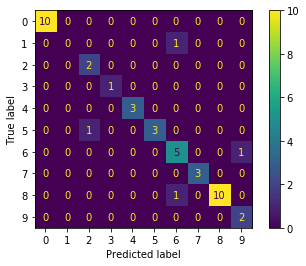

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
ls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # y labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=ls)
disp.plot()
plt.show()

#### <b>Accuracy, Precision, Recall, F1 score<b>

In [89]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(true_labels, predicted_labels)))

print('Micro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(true_labels, predicted_labels, average='weighted')))

print('\nClassification Report\n')
print(classification_report(true_labels, predicted_labels, 
                            target_names=["chihuahua", "beagle", "doberman", "french_bulldog", "golden_retriever", "malamute", "pug", "saint_bernard", "scottish_deerhound", "tibetan_mastiff"]))


Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.80
Macro Recall: 0.85
Macro F1-score: 0.82

Weighted Precision: 0.91
Weighted Recall: 0.91
Weighted F1-score: 0.90

Classification Report

                    precision    recall  f1-score   support

         chihuahua       1.00      1.00      1.00        10
            beagle       0.00      0.00      0.00         1
          doberman       0.67      1.00      0.80         2
    french_bulldog       1.00      1.00      1.00         1
  golden_retriever       1.00      1.00      1.00         3
          malamute       1.00      0.75      0.86         4
               pug       0.71      0.83      0.77         6
     saint_bernard       1.00      1.00      1.00         3
scottish_deerhound       1.00      0.91      0.95        11
   tibetan_mastiff       0.67      1.00      0.80         2

          accuracy                           0.91        43
         macro avg       0.80      0.85 

/Users/reetika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/reetika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### <b>ROC-AUC score<b>

In [95]:
enc_predicted_labels = tf.keras.utils.to_categorical(true_labels, num_classes=10)
print('ROC-AUC score: {:.2f}'.format(roc_auc_score(true_labels, enc_predicted_labels,multi_class='ovr', average='weighted')))

ROC-AUC score: 1.00
